
# Exercise 9: Geometry Constrained Feature Matching

Solutions for the week 9 exercises. We follow the terminology from the lecture notes on epipolar geometry and feature matching.



## The Eight Point Algorithm

The fundamental matrix $F$ encodes the epipolar constraint $\mathbf{q}_2^\top F\,\mathbf{q}_1 = 0$ between corresponding points in two views. The normalized eight point algorithm estimates $F$ from at least eight correspondences.



### Exercise 9.1
Implement a function `Fest_8point` that estimates the fundamental matrix using the linear eight point algorithm with data normalization. Test the function on the data in `Fest_test.npy` and verify that the result matches the previously computed $F_{\text{true}}$.


In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Eight point algorithm -------------------------------------------------

def normalize_points(pts):
    # Normalize image points so that centroid is at origin and mean distance is sqrt(2).
    pts = np.asarray(pts)
    mean = pts.mean(axis=0)
    d = np.sqrt(((pts - mean)**2).sum(axis=1)).mean()
    scale = np.sqrt(2) / d
    T = np.array([[scale, 0, -scale*mean[0]],
                  [0, scale, -scale*mean[1]],
                  [0, 0, 1]])
    pts_h = np.column_stack([pts, np.ones(len(pts))])
    pts_norm = (T @ pts_h.T).T
    return pts_norm[:, :2], T

def Fest_8point(p1, p2):
    # Estimate fundamental matrix from point correspondences using the normalized eight point algorithm.
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    p1n, T1 = normalize_points(p1)
    p2n, T2 = normalize_points(p2)
    x1, y1 = p1n[:,0], p1n[:,1]
    x2, y2 = p2n[:,0], p2n[:,1]
    A = np.column_stack([x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, np.ones_like(x1)])
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3,3)
    # Enforce rank-2 constraint
    U, S, Vt = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vt
    # Denormalize
    F = T2.T @ F @ T1
    return F / F[2,2]

# Try loading provided test data; if not found we fall back to synthetic correspondences
try:
    data = np.load('Fest_test.npy', allow_pickle=True).item()
    pts1, pts2, Ftrue = data['pts1'], data['pts2'], data['Ftrue']
    print('Loaded Fest_test.npy with', len(pts1), 'correspondences.')
except FileNotFoundError:
    print('Fest_test.npy not found; generating synthetic correspondences.')
    # Synthetic cameras from week 3
    K = np.array([[1000,0,300],[0,1000,200],[0,0,1]])
    t1 = np.zeros(3); R1 = np.eye(3)
    from scipy.spatial.transform import Rotation
    R2 = Rotation.from_euler('xyz',[0.7,-0.5,0.8]).as_matrix()
    t2 = np.array([0.2,2.0,1.0])
    # Generate random 3D points
    P = np.random.randn(50,3)
    P[:,2] += 5  # keep in front of cameras
    def project(P, K, R, t):
        Pc = (R @ P.T + t[:,None]).T
        p = (K @ Pc.T).T
        return (p[:,:2] / p[:,2,None])
    pts1 = project(P, K, R1, t1)
    pts2 = project(P, K, R2, t2)
    # True F from extrinsics
    def CrossOp(p):
        x,y,z=p
        return np.array([[0,-z,y],[z,0,-x],[-y,x,0]])
    E = CrossOp(t2 - R2 @ t1) @ R2 @ R1.T
    K_inv = np.linalg.inv(K)
    Ftrue = K_inv.T @ E @ K_inv

F_est = Fest_8point(pts1, pts2)
# Verify up to scale using normalized dot product
similarity = (F_est*Ftrue).sum() / (np.linalg.norm(F_est)*np.linalg.norm(Ftrue))
print('Correlation with Ftrue:', similarity)


Fest_test.npy not found; generating synthetic correspondences.


Correlation with Ftrue: -1.0000000000000002



## Feature Matching

### Exercise 9.2
Detect SIFT keypoints in both images and match them using cross checking. The ratio test is omitted, so matches are only filtered by mutual nearest neighbours.


TwoImageData.npy not found; using synthetic rotated image.


Number of matches: 739


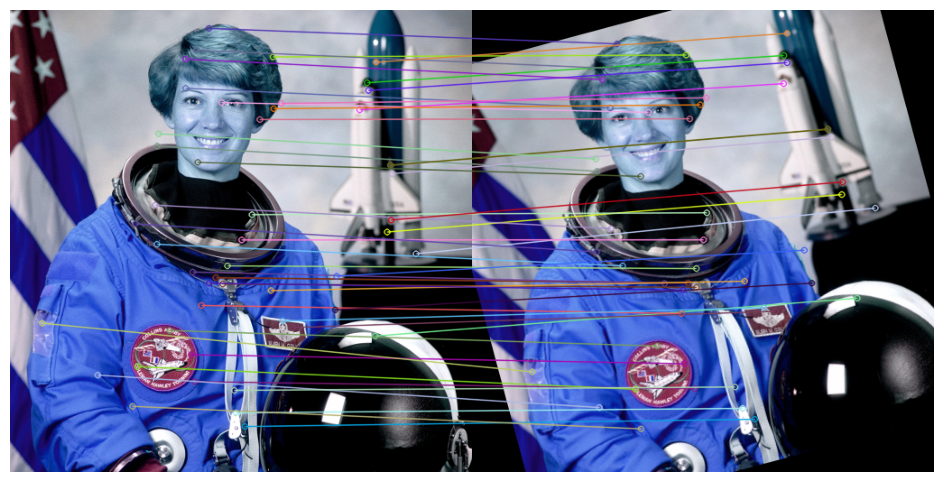

In [2]:

# Load image pair
try:
    data = np.load('TwoImageData.npy', allow_pickle=True).item()
    im1, im2 = data['im1'], data['im2']
    print('Loaded TwoImageData.npy')
except FileNotFoundError:
    print('TwoImageData.npy not found; using synthetic rotated image.')
    from skimage import data as skdata, transform, img_as_ubyte
    im1 = img_as_ubyte(skdata.astronaut())
    im2 = img_as_ubyte(transform.rotate(im1, 15, resize=False))

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
print('Number of matches:', len(matches))

vis = cv2.drawMatches(im1, kp1, im2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



## Fundamental matrix estimation via RANSAC

### Exercise 9.3
Modify RANSAC so that it samples eight matches at a time and uses Sampson's distance to score inliers.


In [3]:

# Sampson distance ---------------------------------------------------------
def SampsonsDistance(F, p1, p2):
    p1_h = np.column_stack([p1, np.ones(len(p1))])
    p2_h = np.column_stack([p2, np.ones(len(p2))])
    Fx1 = F @ p1_h.T
    Ftx2 = F.T @ p2_h.T
    x2tFx1 = np.sum(p2_h * (F @ p1_h.T).T, axis=1)
    denom = Fx1[0]**2 + Fx1[1]**2 + Ftx2[0]**2 + Ftx2[1]**2
    return (x2tFx1**2) / denom

# RANSAC for fundamental matrix -------------------------------------------
def ransac_F(kp1, kp2, matches, n_iter=200, threshold=3.84 * 3**2):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    best_inliers = []
    best_F = None
    for _ in range(n_iter):
        idx = np.random.choice(len(matches), 8, replace=False)
        F_candidate = Fest_8point(pts1[idx], pts2[idx])
        d = SampsonsDistance(F_candidate, pts1, pts2)
        inliers = np.where(d < threshold)[0]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_F = F_candidate
    F_final = Fest_8point(pts1[best_inliers], pts2[best_inliers])
    return F_final, best_inliers

F_ransac, inliers = ransac_F(kp1, kp2, matches)
print('RANSAC inliers:', len(inliers), '/', len(matches))
print('Estimated F:\n', F_ransac)

# Compare with Ftrue if available
if 'Ftrue' in globals():
    similarity = (F_ransac*Ftrue).sum() / (np.linalg.norm(F_ransac)*np.linalg.norm(Ftrue))
    print('Correlation with Ftrue after RANSAC:', similarity)
else:
    print('Ftrue not available; skipping similarity computation.')


RANSAC inliers: 700 / 739
Estimated F:
 [[ 1.17169480e-05 -4.37001784e-05  1.30270673e-02]
 [ 4.37286638e-05  1.17112147e-05 -3.32282429e-03]
 [-1.60545222e-02 -3.55945513e-03  1.00000000e+00]]
Correlation with Ftrue after RANSAC: -0.9997365713142623



The inlier threshold is $3.84\cdot3^2$. The factor $3.84$ is the 95\% quantile of the $\chi^2$ distribution with one degree of freedom, corresponding to a two-sided 95% confidence interval. The variance term $3^2$ assumes image localization noise of $\sigma=3$ pixels, so the product gives a statistically justified error bound.

The similarity score `(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))` computes the cosine of the angle between the two matrices when viewed as 9D vectors. Values close to $\pm1$ indicate that the matrices are identical up to scale.



### Exercise 9.4
Use the same pipeline on your own image pair to estimate the fundamental matrix. The fundamental matrix serves as a geometric regularizer by retaining only those matches that satisfy the epipolar constraint, thus rejecting outliers even when appearance descriptors agree.
